In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

In [3]:
import cv2

In [4]:
video_ocr_paths = list(Path("../data/video_frame_obj").glob("*.csv"))

In [5]:
video_ocr_paths[:2]

[WindowsPath('../data/video_frame_obj/test_video_0.csv'),
 WindowsPath('../data/video_frame_obj/test_video_1.csv')]

In [6]:
diff_df_dict = dict()
for video_ocr_path in video_ocr_paths:
    file_name = video_ocr_path.name.split(".")[0]
    diff_df_dict[file_name] = pd.read_csv(video_ocr_path)

In [7]:
diff_df = diff_df_dict['test_video_13']
diff_df.head()

,index,dissimilarity,jaccard,jaccard_letter,frame_token_ct,lev_dis,word_dis,letter_dissim,min
0,1,0.073178,0.2,0.478261,4,0.368421,0.200000,0.157895,0.016667
1,2,0.036582,0.2,0.478261,5,0.187500,0.200000,0.157895,0.033333
2,3,0.073881,0.4,0.476190,4,0.062500,0.000000,0.000000,0.050000
3,4,0.194590,0.6,0.705882,4,1.666667,0.250000,0.625000,0.066667
4,5,1.000000,1.0,1.000000,3,6.000000,0.666667,1.000000,0.083333


In [8]:
import json
with open('labels.json', 'r') as file:
    labels = json.load(file)
labels.keys()

dict_keys(['test_video_0', 'test_video_1', 'test_video_10', 'test_video_11', 'test_video_12'])

In [9]:
def create_label_function(labels:list):
    return lambda index_ : True if index_ in labels else False

In [10]:
create_label_function(labels['test_video_0'])(3467)

True

In [ ]:
v

## load ocr results

In [11]:
video_ocr_result_paths = list(Path("../data/video_ocr_results").glob("*.json"))

ocr_dict = dict()
for video_ocr_path in video_ocr_result_paths:
    file_name = video_ocr_path.name.split(".")[0]
    
    print(video_ocr_path)
    with open(video_ocr_path.absolute(), 'r') as file:
        test_ocr_results = json.load(file)
        
    ocr_dict[file_name] = test_ocr_results 

..\data\video_ocr_results\test_video_0.json
..\data\video_ocr_results\test_video_1.json
..\data\video_ocr_results\test_video_10.json
..\data\video_ocr_results\test_video_11.json
..\data\video_ocr_results\test_video_12.json
..\data\video_ocr_results\test_video_13.json
..\data\video_ocr_results\test_video_14.json
..\data\video_ocr_results\test_video_15.json
..\data\video_ocr_results\test_video_16.json
..\data\video_ocr_results\test_video_17.json
..\data\video_ocr_results\test_video_18.json
..\data\video_ocr_results\test_video_19.json
..\data\video_ocr_results\test_video_2.json
..\data\video_ocr_results\test_video_20.json
..\data\video_ocr_results\test_video_3.json
..\data\video_ocr_results\test_video_4.json
..\data\video_ocr_results\test_video_5.json
..\data\video_ocr_results\test_video_6.json
..\data\video_ocr_results\test_video_7.json
..\data\video_ocr_results\test_video_8.json
..\data\video_ocr_results\test_video_9.json


## training model

In [12]:
train_df = pd.DataFrame()
train_df_lst = []
for video_name, label_frames in labels.items():
    diff_df = diff_df_dict[video_name].iloc[2:,].copy() #remove the first 2 frames
    diff_df['video_index'] = diff_df['index']
    
    label_function = create_label_function(label_frames)
    diff_df['new_slide'] = diff_df['index'].apply(label_function)
    diff_df['video_name'] = video_name
    train_df_lst.append(diff_df)
    

In [13]:
pd.concat(train_df_lst)['new_slide'].sum(), pd.concat(train_df_lst)['new_slide'].mean()

(166, 0.009885071160602632)

In [14]:
train_df = pd.concat(train_df_lst, ignore_index=True)
# not use nlp's dissimilarity
train_df['dissimilarity'] = train_df['jaccard']
#train_df = train_df.drop(['lev_dis', 'index'], axis=1)

train_df = train_df.drop([ 'index', 'min'], axis=1)
train_df.head()

,dissimilarity,jaccard,jaccard_letter,frame_token_ct,lev_dis,word_dis,letter_dissim,video_index,new_slide,video_name
0,0.000000,0.000000,0.720000,4,0.000000,0.000000,0.000000,3,False,test_video_0
1,0.000000,0.000000,0.720000,4,0.000000,0.000000,0.000000,4,False,test_video_0
2,0.954545,0.954545,0.855670,4,0.797468,0.789474,0.594937,5,True,test_video_0
3,0.272727,0.272727,0.890459,19,0.102564,0.000000,0.012658,6,False,test_video_0
4,0.304348,0.304348,0.892361,19,0.110429,0.050000,0.042945,7,False,test_video_0


In [15]:
train_df.columns

Index(['dissimilarity', 'jaccard', 'jaccard_letter', 'frame_token_ct',
       'lev_dis', 'word_dis', 'letter_dissim', 'video_index', 'new_slide',
       'video_name'],
      dtype='object')

In [16]:
feature_names = ['jaccard', 'jaccard_letter', 'frame_token_ct',
       'word_dis', 'letter_dissim']
#'dissimilarity', 

In [17]:
train_df['video_name']

0         test_video_0
1         test_video_0
2         test_video_0
3         test_video_0
4         test_video_0
             ...      
16788    test_video_12
16789    test_video_12
16790    test_video_12
16791    test_video_12
16792    test_video_12
Name: video_name, Length: 16793, dtype: object

In [18]:
X = train_df.query("video_name!='test_video_12'")[feature_names].fillna(0)
y = train_df.query("video_name!='test_video_12'")['new_slide']

In [19]:
x_test = train_df.query("video_name=='test_video_12'")[feature_names].fillna(0)
y_test = train_df.query("video_name=='test_video_12'")['new_slide']

In [20]:
from sklearn.datasets import load_iris
from sklearn import tree
seed =12345
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=seed)
clf = clf.fit(X, y)

dummy_clf = tree.DecisionTreeClassifier(max_depth=2, random_state=seed)
dummy_clf  = dummy_clf.fit(X, y)


In [21]:
y_pred = clf.predict(X)
dummy_y_pred = dummy_clf.predict(X)
my_dummy_y_pred = X['jaccard']   >= 0.1
y_true = y



# keep probabilities for the positive outcome only
from sklearn.metrics import precision_recall_curve
lr_probs = clf.predict_proba(X)
lr_probs = lr_probs[:, 1]
# predict class values
y_pred = clf.predict(X)
# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_true, lr_probs)

## model export

In [22]:
from joblib import dump, load
dump(clf, '../models/ocr_tree.joblib') 

['../models/ocr_tree.joblib']

In [23]:
MODEL_PATH = '../models/ocr_tree.joblib'
clf = load(MODEL_PATH) 

## tree visualization

In [24]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("tree") 

'tree.pdf'

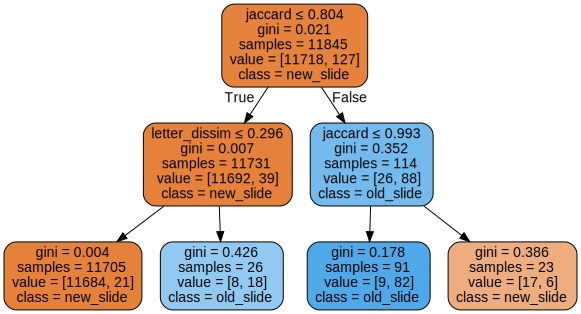

In [25]:
dot_data = tree.export_graphviz(dummy_clf, out_file=None, 
                      feature_names=feature_names,  
                      class_names=['new_slide', 'old_slide'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

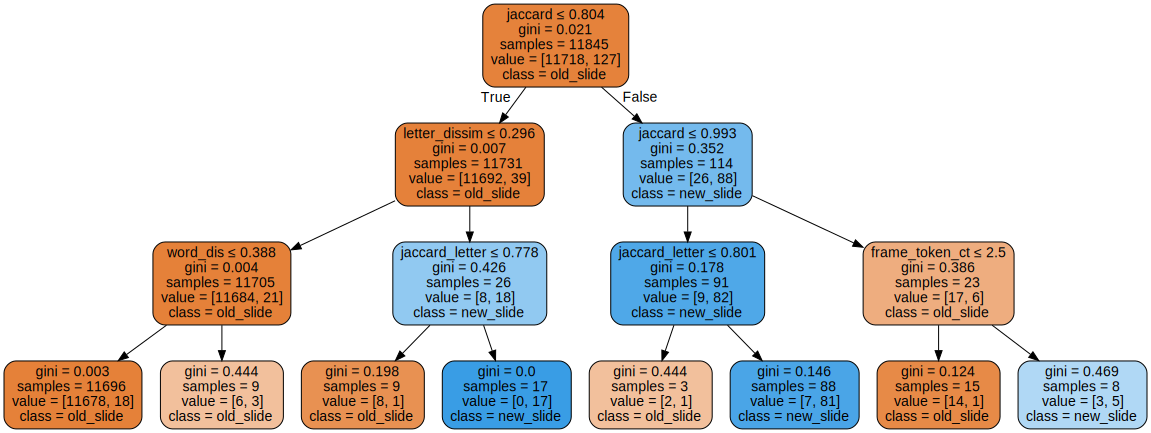

In [26]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=feature_names,  
                      class_names=['old_slide', 'new_slide'],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [27]:
import pydot

(graph,) = pydot.graph_from_dot_data(dot_data)
graph.write_png('somefile.png')

In [28]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     11718
        True       0.91      0.81      0.86       127

    accuracy                           1.00     11845
   macro avg       0.95      0.91      0.93     11845
weighted avg       1.00      1.00      1.00     11845



In [29]:
confusion_matrix(y_true, y_pred)

array([[11708,    10],
       [   24,   103]], dtype=int64)

In [30]:
##### 
confusion_matrix(y_true, dummy_y_pred) #missed 25, 43 

array([[11701,    17],
       [   27,   100]], dtype=int64)

In [31]:
cm = confusion_matrix(y_true, my_dummy_y_pred)
cm

array([[2226, 9492],
       [   3,  124]], dtype=int64)

In [32]:
# testing on video12
y_test_pred = clf.predict(x_test)
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[4909,    0],
       [   1,   38]], dtype=int64)

## looking at training error instances

In [33]:
train_df.reset_index().merge(X[y_true != y_pred].reset_index()[['index']], how='right')['video_name'].value_counts()

test_video_10    14
test_video_0     10
test_video_11     8
test_video_1      2
Name: video_name, dtype: int64

In [34]:
X_labels = pd.concat([X, pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})],axis=1)
X_labels

,jaccard,jaccard_letter,frame_token_ct,word_dis,letter_dissim,y_true,y_pred
0,0.000000,0.720000,4,0.000000,0.000000,False,False
1,0.000000,0.720000,4,0.000000,0.000000,False,False
2,0.954545,0.855670,4,0.789474,0.594937,True,True
3,0.272727,0.890459,19,0.000000,0.012658,False,False
4,0.304348,0.892361,19,0.050000,0.042945,False,False
...,...,...,...,...,...,...,...
11840,0.200000,0.702381,8,0.200000,0.152542,False,False
11841,0.090909,0.731959,10,0.090909,0.078125,False,False
11842,0.307692,0.734694,11,0.000000,0.062500,False,False
11843,0.083333,0.737374,11,0.083333,0.076923,False,False


In [35]:
x_false_negatives = X_labels.query("y_true and (not y_pred)")

In [36]:
train_df.iloc[2248,]

dissimilarity         0.555556
jaccard               0.555556
jaccard_letter        0.926087
frame_token_ct              33
lev_dis               0.272358
word_dis              0.030303
letter_dissim       0.00806452
video_index               2251
new_slide                 True
video_name        test_video_0
Name: 2248, dtype: object

In [37]:
diff_df_dict['test_video_0'].iloc[2250,]

index             2251.000000
dissimilarity        0.091521
jaccard              0.555556
jaccard_letter       0.926087
frame_token_ct      33.000000
lev_dis              0.272358
word_dis             0.030303
letter_dissim        0.008065
min                 37.516667
Name: 2250, dtype: float64

In [38]:
# 2251, words are exactly the same 

In [39]:
def get_paragraph(ocr_result: list, threshold: float=0.9):
    return " ".join(list(map(lambda lst: lst[-1][0],filter(lambda lst: lst[-1][-1] >threshold, ocr_result))))


def get_paragraph_line(ocr_result: list, threshold: float=0.9):
    return "\n".\
        join(list(map(lambda lst: lst[-1][0],filter(lambda lst: lst[-1][-1] >threshold, ocr_result))))

In [40]:
print(get_paragraph_line(ocr_dict['test_video_0']['3455']))

Bottom line
days
Understand the business problem
Understand how models are evaluated
Act accordingly
Have fun!
days
Christian Dior
LOUIS VUITTON SEPHORA
LVMH
kaggle
KAGGLE DAYSPARIS.JAN25-26TH.2019


In [41]:
print(get_paragraph_line(ocr_dict['test_video_0']['3456']))

ORGANIZERSANDSPONSORS
LVMH
Christian Dior
LOUIS VUITTON
SEPHORA
COUTUR
kaggle


In [42]:
train_df.reset_index().merge(x_false_negatives.reset_index()[['index']], how='right').\
    sort_values(['video_name', 'video_index'])

,index,dissimilarity,jaccard,jaccard_letter,frame_token_ct,lev_dis,word_dis,letter_dissim,video_index,new_slide,video_name
0,2248,0.555556,0.555556,0.926087,33,0.272358,0.030303,0.008065,2251,True,test_video_0
1,2320,0.769231,0.769231,0.933747,29,0.529412,0.171429,0.106618,2323,True,test_video_0
2,2893,0.685714,0.685714,0.916883,17,0.465116,0.413793,0.060465,2896,True,test_video_0
3,3458,0.461538,0.461538,0.885542,9,0.518519,0.181818,0.287037,3461,True,test_video_0
4,3464,1.000000,1.000000,1.000000,2,28.000000,0.500000,1.000000,3467,True,test_video_0
5,3472,0.535714,0.535714,0.930599,19,0.071429,0.136364,0.017544,10,True,test_video_1
6,5225,0.666667,0.666667,0.652174,3,1.875000,0.666667,0.652174,1763,True,test_video_1
7,5242,0.833333,0.833333,0.720000,3,0.125000,0.250000,0.000000,19,True,test_video_10
8,5245,0.000000,0.000000,0.720000,4,0.000000,0.000000,0.000000,22,True,test_video_10
9,5250,0.571429,0.571429,0.766667,4,0.195122,0.333333,0.195122,27,True,test_video_10


## test new df

In [43]:
feature_names

['jaccard', 'jaccard_letter', 'frame_token_ct', 'word_dis', 'letter_dissim']

In [44]:
test_feature_df = pd.read_csv("../slide_segmentation/slide_segmentator/tmp/video_ocf_features/test_video_0.csv")

In [45]:
test_feature_df = test_feature_df.rename(columns={'letter_dis':'letter_dissim'})
test_feature_df['dissimilarity'] = 1

In [46]:
test_feature_df.columns

Index(['index', 'jaccard_letter', 'jaccard', 'letter_dissim', 'word_dis',
       'frame_token_ct', 'dissimilarity'],
      dtype='object')

In [47]:
test_feature_df.head()

,index,jaccard_letter,jaccard,letter_dissim,word_dis,frame_token_ct,dissimilarity
0,1,1.00000,1.00,1.000000,0.857143,79,1
1,2,0.00000,0.75,0.131868,0.000000,91,1
2,3,0.00000,0.00,0.000000,0.000000,91,1
3,4,0.00000,0.00,0.000000,0.000000,91,1
4,5,0.09375,0.90,0.616034,0.750000,237,1


In [48]:
test_feature_df['prediction'] = clf.predict(test_feature_df[feature_names])

In [49]:
test_feature_df

,index,jaccard_letter,jaccard,letter_dissim,word_dis,frame_token_ct,dissimilarity,prediction
0,1,1.00000,1.000000,1.000000,0.857143,79,1,True
1,2,0.00000,0.750000,0.131868,0.000000,91,1,False
2,3,0.00000,0.000000,0.000000,0.000000,91,1,False
3,4,0.00000,0.000000,0.000000,0.000000,91,1,False
4,5,0.09375,0.900000,0.616034,0.750000,237,1,False
5,6,0.00000,0.055556,0.008439,0.000000,235,1,False
6,7,0.00000,0.055556,0.008439,0.000000,237,1,False
7,8,0.00000,0.055556,0.008439,0.000000,235,1,False
8,9,0.00000,0.105263,0.016736,0.000000,239,1,False
9,10,0.00000,0.000000,0.000000,0.000000,239,1,False
